In [1]:
# Import Dependencies
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Read datasets
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
order_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [4]:
# Merge datasets
order = order_train.merge(orders, on=['order_id'], how = 'inner')
order = order.merge(products, on=['product_id'], how = 'inner')
order = order.merge(aisles, on=['aisle_id'], how = 'inner')
order_df = order.merge(departments, on=['department_id'], how = 'inner')
order_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,47901,train,14,4,6,16.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,2993,train,15,0,7,7.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,41425,train,4,3,8,14.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,187205,train,5,4,14,30.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [5]:
# Creat fake e-mail for user_id
user = orders['user_id'].unique()
user_df = pd.DataFrame(user, columns = ['user_id'])
user_df['email'] = [f'user_{user}@gmail.com' for user in user_df['user_id']]
user_df.head()

,user_id,email
0,1,user_1@gmail.com
1,2,user_2@gmail.com
2,3,user_3@gmail.com
3,4,user_4@gmail.com
4,5,user_5@gmail.com


In [6]:
# Remove columns not needed
order_df = order_df.drop(columns = ['eval_set', 'order_number','order_dow'], axis =1)
order_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,47901,6,16.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,2993,7,7.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,41425,8,14.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,187205,14,30.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [7]:
# Check If There Are Repeat Customers
# Groupby User, Product ID and Product Name
top_user = order_df.groupby(['user_id','product_id','product_name']).size().reset_index(name = "count")
top_user = pd.DataFrame(top_user)

# Unique Values in Count Are 1 Meaning This Dataset is of Unique Customers
len(pd.unique(top_user['count']))

1

In [ ]:
# Print Number of Aisles and Departments
print( len(pd.unique(order_df['aisle'])), len(pd.unique(order_df['department'])), len(pd.unique(order_df['product_id'])))

# Not many departments compare to aisles, too many products to run as features
# so to have cluster that runs fast without enough features we'll focus on aisles

## Top Products in Aisle

In [8]:
# TOP Products in Aisle
top_aisle = order_df.groupby(['aisle_id','aisle','product_id','product_name']).size().reset_index(name = "count")
top_aisle = pd.DataFrame(top_aisle)
top_aisle.head()

,aisle_id,aisle,product_id,product_name,count
0,1,prepared soups salads,209,Italian Pasta Salad,8
1,1,prepared soups salads,554,Turkey Chili,56
2,1,prepared soups salads,886,Whole Grain Salad with Roasted Pecans & Mango ...,1
3,1,prepared soups salads,1600,Mediterranean Orzo Salad,5
4,1,prepared soups salads,2539,Original Potato Salad,33


In [9]:
# TOP 3 Products in Aisle
# Sort Descending on Count
top_aisle = top_aisle.sort_values(by='count', ascending = False)

# Sort Ascending on Aisle
top_aisle = top_aisle.sort_values(by='aisle_id')

# Get Unique aisle_id List
unique_aisle = pd.unique(top_aisle['aisle_id'])

# Get initial dataframe to concat
inital_df = top_aisle.loc[top_aisle['aisle_id'] == unique_aisle[0]].nlargest(3, columns='count')

# Creat for loop to concat top 3 product of each aisle
for i in range(1,len(unique_aisle)):
    top_3 = top_aisle.loc[top_aisle['aisle_id'] == unique_aisle[i]].nlargest(3, columns='count')
    inital_df = pd.concat([inital_df,top_3])
    
top3_aisle = inital_df
top3_aisle.head()

,aisle_id,aisle,product_id,product_name,count
61,1,prepared soups salads,26047,Tuna Salad,208
57,1,prepared soups salads,25199,Classic Chicken Salad,200
50,1,prepared soups salads,22281,Chicken Noodle Soup,165
293,2,specialty cheeses,37524,Fresh Mozzarella Ball,450
194,2,specialty cheeses,13409,Dubliner Wedge Pre Cut Cheese,253


In [10]:
# List of Repeated Purchases
reorder = order_df[order_df['reordered']==1]
reorder_df = reorder[['product_id', 'user_id', 'product_name', 'aisle_id', 'department_id', 'aisle', 'department']]
reorder_df.head()

,product_id,user_id,product_name,aisle_id,department_id,aisle,department
0,49302,112108,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,49302,47901,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,49302,2993,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,49302,41425,Bulgarian Yogurt,120,16,yogurt,dairy eggs
5,49302,199120,Bulgarian Yogurt,120,16,yogurt,dairy eggs


## Model (K-Means)

In [11]:
# Transform Table to be Percentage of Aisle Purchases For User
# Calculate Percentage of User
percent_user = order_df.groupby(['user_id','aisle_id','aisle']).size().reset_index(name='count')

sum_userproduct = percent_user.groupby(['user_id'])['count'].sum().reset_index(name='sum')

# Merge two count and sum dataset to calculate aisle percentage
percent_user = percent_user.merge(sum_userproduct, on='user_id')
percent_user['percent'] = percent_user['count']/percent_user['sum']
percent_user.head()

,user_id,aisle_id,aisle,count,sum,percent
0,1,21,packaged cheese,1,11,0.090909
1,1,23,popcorn jerky,1,11,0.090909
2,1,45,candy chocolate,1,11,0.090909
3,1,53,cream,1,11,0.090909
4,1,54,paper goods,1,11,0.090909


In [25]:
# Create user product aisle percentage table
percent_df = pd.pivot_table(percent_user, values='percent', index='user_id', columns = 'aisle', fill_value = 0 )
percent_df = percent_df.sort_index()
percent_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.090909
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.111111,0.222222,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.055556,0.055556,0.0,0.0,0.0,0.0,0.0,0.000000


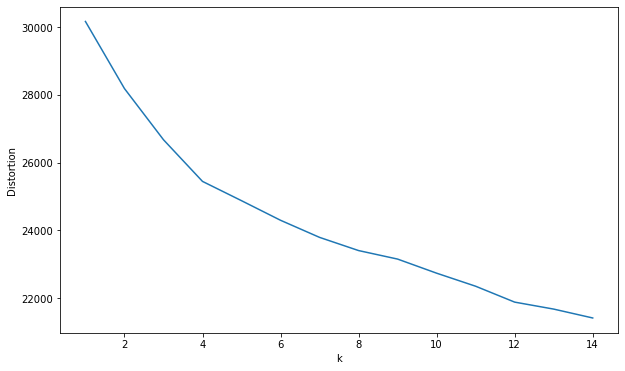

In [16]:
# Model K-means
from sklearn.cluster import KMeans

distortions = []
for k in range(1,15):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(percent_df)
    distortions.append(kmeanModel.inertia_)
    
# Plot Distortion to Determine Elbow/Optimal k-value
plt.figure(figsize=(10,6))
plt.plot(range(1,15), distortions)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

# Elbow is around 6 so we'll use 6 for number of clusters

In [17]:
# Fit model k-mean with 6 clusters
kmeans = KMeans(n_clusters = 6).fit(percent_df)

# Pull Cluster Labels for rows
cluster_label = kmeans.labels_

In [18]:
# Pivot Count For User and Aisle
percent_ct = pd.pivot_table(percent_user, values='count', index='user_id', columns = 'aisle', fill_value = 0 )
# Add Cluster Labels to Dataframe To Identify Customer Segment
percent_ct['cluster'] = cluster_label
# Display preview
percent_ct.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
5,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4
8,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1


In [19]:
# Sum Count of Bought Products in Aisle
cluster_summary = percent_ct.groupby('cluster').sum()
cluster_summary = cluster_summary.reset_index(drop=False)
cluster_summary.head()

aisle,cluster,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,0,1,6,0,0,3,2,13,0,0,...,17,18,5,2,5,0,4,74,0,79
1,1,88,1928,37,38,1280,175,2436,150,30,...,1726,1162,1485,1761,77,128,293,4378,90,8281
2,2,0,6,0,0,0,29,56,9,0,...,88,8,1,16,30,19,2,303,1,99
3,3,105,1288,64,66,3261,309,2556,139,46,...,3114,1929,1124,1992,309,209,485,7776,86,16554
4,4,870,3755,205,223,8647,982,7993,791,210,...,7109,6155,2502,4578,1023,1247,1168,18205,902,30107


In [20]:
# Unpivot table 
df_unpivoted = cluster_summary.melt(id_vars=['cluster'], var_name='aisle', value_name='count')
df_unpivoted = df_unpivoted.sort_values('count', ascending = False)
df_unpivoted.head()

,cluster,aisle,count
319,1,fresh vegetables,90903
303,3,fresh fruits,81483
301,1,fresh fruits,32070
802,4,yogurt,30107
321,3,fresh vegetables,30017


In [21]:
# Calculate Cluster Aisle Sum/Total
cluster_ttl = pd.DataFrame(cluster_summary.sum(axis=1), columns=['total'])

# Determine Percentage of Aisle in Cluster
percent_cluster=[]
for i in range(6):
    filter_df = df_unpivoted[df_unpivoted['cluster'] == i].reset_index(drop=True)
    filter_df['percent'] = filter_df['count']/cluster_ttl['total'][i]
    percent_cluster.append(filter_df)

percent_cluster = pd.concat(percent_cluster)
percent_cluster.head()

,cluster,aisle,count,percent
0,0,fresh fruits,5251,0.716176
1,0,packaged vegetables fruits,355,0.048418
2,0,fresh vegetables,226,0.030824
3,0,packaged produce,183,0.024959
4,0,milk,124,0.016912


<ipython-input-22-f262ea894f0a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-22-f262ea894f0a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-22-f262ea894f0a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-22-f262ea894f0a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-22-f262ea894f0a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-22-f262ea894f0a>:10: UserWarning: FixedFormatter should only be used together with Fi

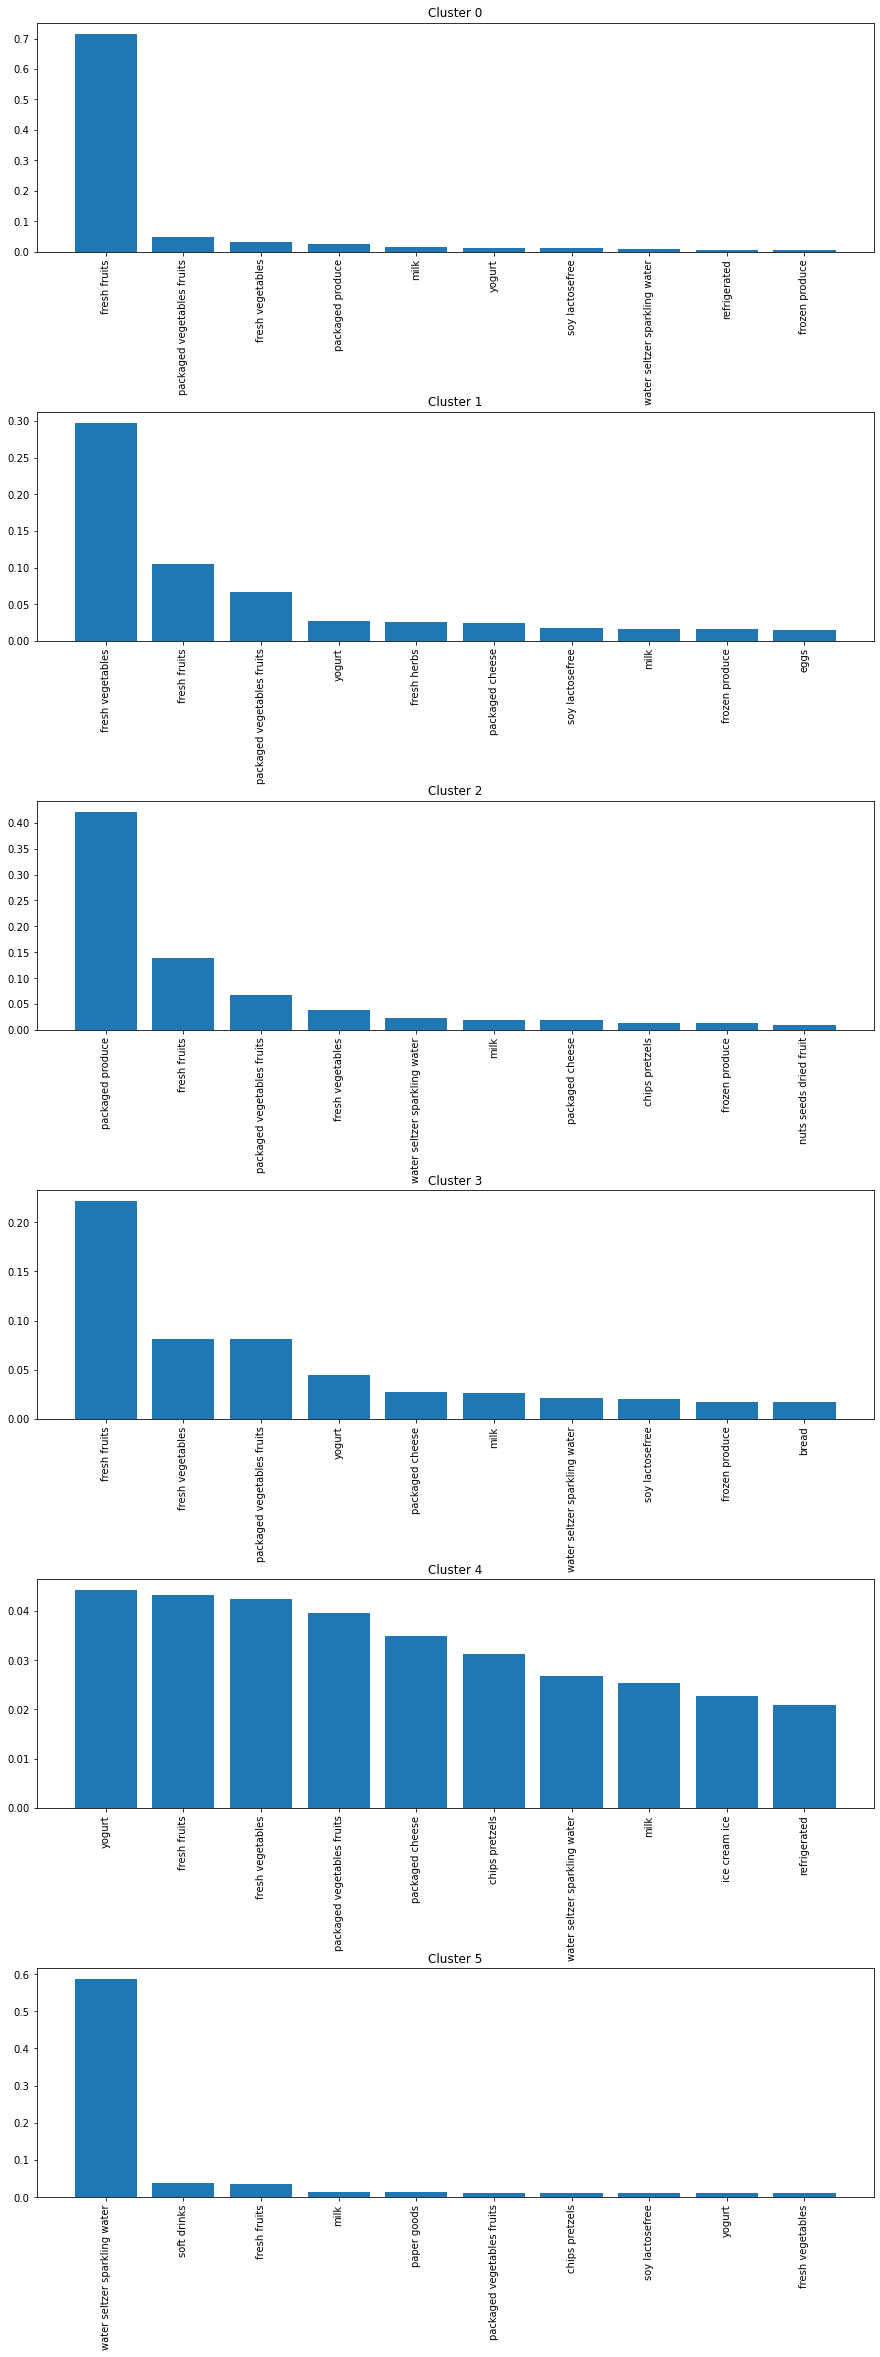

In [22]:
# Graph Top 10 Aisle in Clusters
import matplotlib.pyplot as plt
fig, axs = plt.subplots(6, figsize = (15,40))
fig.subplots_adjust(hspace=.7)
for i in range(6):
    filter_df = percent_cluster[percent_cluster['cluster'] == i].reset_index(drop=True)
    filter_df = filter_df.iloc[0:10]
    axs[i].bar(filter_df['aisle'], filter_df['percent'])
    axs[i].title.set_text(f'Cluster {i}')
    axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)

# 6 Clusters Define
# (1) Cluster 0: Heavy on Fresh Fruits, followed by Fresh/Packaged Vege
# (2) Cluster 1: Mainly Fresh Vege, followed by Fresh Fruits
# (3) Cluster 2: Mainly Packaged Vege, followed by Fresh Fruits
# (4) Cluster 3: Mainly Fresh Fruits, followed by Fresh Veges
# (5) Cluster 4: Balanced/Equal Aisle Distribution
# (6) Cluster 5: Mainly Sparking Water and Other Beverages Aisles

In [23]:
# Determine Top 10 Products in Each cluster
# Convert table to count products
percent_ct = percent_ct.reset_index(drop=False)
top_cluster = percent_ct[['user_id','cluster']]
# Count product in each cluster
cluster_product = order_df[['user_id', 'product_id','product_name','aisle']].merge(top_cluster, on="user_id")
cluster_count = cluster_product.groupby(['cluster','product_name'])['product_id'].count().reset_index(name='count')
cluster_count = cluster_count.sort_values('count',ascending=False)

# Sort Cluster
cluster_list = sorted(cluster_count['cluster'].unique())
inital_df = cluster_count[cluster_count['cluster'] == 0][0:10]

for i in range(1, len(cluster_list)):
    top_df = cluster_count[cluster_count['cluster'] == i][0:10]
    inital_df = pd.concat([inital_df, top_df])

cluster_top10 = inital_df
cluster_top10.head()

,cluster,product_name,count
86,0,Bag of Organic Bananas,559
93,0,Banana,424
871,0,Organic Strawberries,353
1143,0,Strawberries,229
480,0,Large Lemon,137


In [24]:
aisle_list = sorted(order_df['aisle'].unique())

## Recommendations & Test

In [ ]:
# Take a point from the table to test


In [ ]:
# Calculate Percentage of User
percent_user = test_df.groupby(['user_id','aisle_id','aisle']).size().reset_index(name='count')

sum_userproduct = percent_user.groupby(['user_id'])['count'].sum().reset_index(name='sum')

# Merge two count and sum dataset to calculate aisle percentage
percent_user = percent_user.merge(sum_userproduct, on='user_id')
percent_user['percent'] = percent_user['count']/percent_user['sum']
percent_user.head()

In [ ]:
percent_df = pd.pivot_table(percent_user, values='percent', index='user_id', columns = 'aisle', fill_value = 0 )
percent_df.head()

In [ ]:
kmeans.predict(percent_df.to_numpy()[1].reshape(-1,134))

In [ ]:
#

In [ ]:
def recommendations(user_email):
    user_email = str(user_email)
    
    # Convert e-mail to user_id
    user_id = int(user_df.loc[user_df['email'] == user_email, 'user_id'])
    
    # Fit user_id on model, return cluster 
    kmeans.fit/predict
    cluster_num = 1
    cluster_top10[cluster_top10['cluster'] == cluster_num]
    test_df[test_df['user_id'] == ]
    
    

In [ ]:
cluster_top10[cluster_top10['cluster']==3]

In [ ]:
from selenium import webdriver
import time
wd = webdriver.Chrome(executable_path="./chromedriver.exe")

In [ ]:
'hello!'.replace('!','')

In [ ]:
def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    clean_query = query.replace('%', '')
    wd.get(search_url.format(q=clean_query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

In [ ]:
url_list = []
for product in cluster_top10['product_name']:
    img_url = fetch_image_urls(query=product, max_links_to_fetch=1, wd=wd, sleep_between_interactions=3)
    url_list.append(img_url.pop())
    
cluster_top10['img_url'] = url_list
cluster_top10.head()

In [ ]:
cluster_top10.to_csv("cluster_top10.csv")